## Import des données et pré-traitement

In [8]:
import pandas as pd 
from src.utility.descriptive_statistics import descriptive_statistics
from src.graph.graph import plot_time_series
from src.utility.date import get_t, get_T

df = pd.read_pickle('src/data/panel_data.pkl')
df["index"] = pd.to_datetime(df["index"])


outlier_dates = [pd.Timestamp('2001-09-11')]
df = df[~df['index'].isin(outlier_dates)]

df = df[(df['index'] >= '1988-02-01') & (df['index'] <= '2015-01-01')]


for col in df.columns[1:]:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df['t'] = df['index'].apply(get_t)
df[['T1', 'T2', 'T3', 'T4', 'T5']] = df['index'].apply(lambda x: pd.Series(get_T(x)))
df

,index,Maturity 1,Maturity 2,Maturity 3,Maturity 4,Maturity 5,t,T1,T2,T3,T4,T5
0,1988-02-01,197.75,203.75,206.75,208.50,210.50,0.915068,1988-03-15,1988-05-15,1988-07-15,1988-09-14,1988-12-15
1,1988-02-02,198.25,203.75,206.75,207.50,209.75,0.912329,1988-03-15,1988-05-15,1988-07-15,1988-09-14,1988-12-15
2,1988-02-03,198.75,204.00,207.25,208.25,211.25,0.909589,1988-03-15,1988-05-15,1988-07-15,1988-09-14,1988-12-15
3,1988-02-04,202.75,207.75,210.75,212.50,216.00,0.906849,1988-03-15,1988-05-15,1988-07-15,1988-09-14,1988-12-15
4,1988-02-05,201.25,207.00,210.50,212.00,214.25,0.904110,1988-03-15,1988-05-15,1988-07-15,1988-09-14,1988-12-15
...,...,...,...,...,...,...,...,...,...,...,...,...
6784,2014-12-24,407.75,416.25,423.00,426.25,432.25,0.019178,2015-03-15,2015-05-15,2015-07-15,2015-09-14,2015-12-15
6785,2014-12-26,414.75,423.00,429.75,432.50,439.00,0.013699,2015-03-15,2015-05-15,2015-07-15,2015-09-14,2015-12-15
6786,2014-12-29,412.75,421.25,428.00,430.75,436.75,0.005479,2015-03-15,2015-05-15,2015-07-15,2015-09-14,2015-12-15
6787,2014-12-30,406.50,415.00,421.75,424.75,430.75,0.002740,2015-03-15,2015-05-15,2015-07-15,2015-09-14,2015-12-15


## Statistiques descriptives

In [9]:
import numpy as np

original_stats, log_stats = descriptive_statistics(df["Maturity 1"])

stats_keys = ['Mean', 'Median', 'Minimum', 'Maximum', 'Std deviation', 'Skewness', 'Kurtosis', 'Autocorrelation', 'ADF test p-value (10 lags)', 'Nb obs']
df_combined_stats = pd.DataFrame(index=stats_keys, columns=['Prices (c/bu)', 'Log returns'])

for key in stats_keys:
    df_combined_stats.loc[key, 'Prices (c/bu)'] = original_stats.get(key, np.nan)
    log_key = 'Log ' + key  
    df_combined_stats.loc[key, 'Log returns'] = log_stats.get(log_key, np.nan)
df_combined_stats

,Prices (c/bu),Log returns
Mean,325.4715,0.0001
Median,262.25,0.0
Minimum,174.75,-0.272
Maximum,831.25,0.128
Std deviation,148.6452,0.0173
Skewness,1.55,-1.08
Kurtosis,1.43,20.22
Autocorrelation,0.999,0.052
ADF test p-value (10 lags),0.21,0.0
Nb obs,6788,6787


## Graphiques


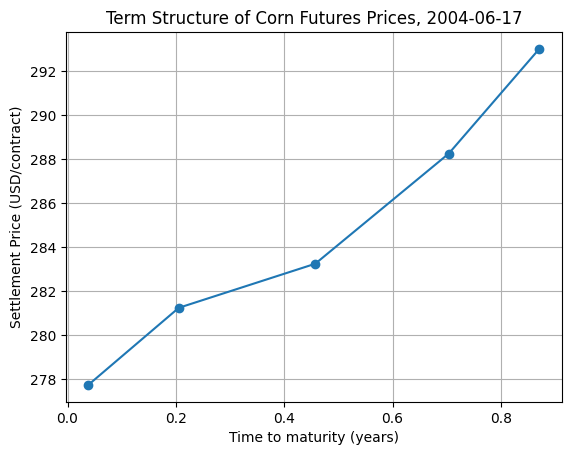

In [10]:
import matplotlib.pyplot as plt

df['index'] = pd.to_datetime(df['index'], errors='coerce')

df.set_index('index', inplace=True)

# Date cible pour l'analyse
target_date = '2004-06-17'

# Obtenir les prix à cette date spécifique
prix_17_06_2004 = df.loc[target_date, ['Maturity 1', 'Maturity 2', 'Maturity 3', 'Maturity 4', 'Maturity 5']]

# Obtenir les dates d'échéance (T1, T2, T3, T4, T5)
maturity_dates = df.loc[target_date, ['T1', 'T2', 'T3', 'T4', 'T5']]

# Calculer le temps jusqu'à l'échéance en années
time_to_maturity = [(((maturity - pd.Timestamp(target_date)).days - 14) / 365.25) for maturity in maturity_dates]

# Tracer le graphique des prix en fonction du temps jusqu'à l'échéance
plt.plot(time_to_maturity, prix_17_06_2004.values, marker='o', linestyle='-')
plt.xlabel('Time to maturity (years)')
plt.ylabel('Settlement Price (USD/contract)')
plt.title(f'Term Structure of Corn Futures Prices, {target_date}')
plt.grid()
plt.show()


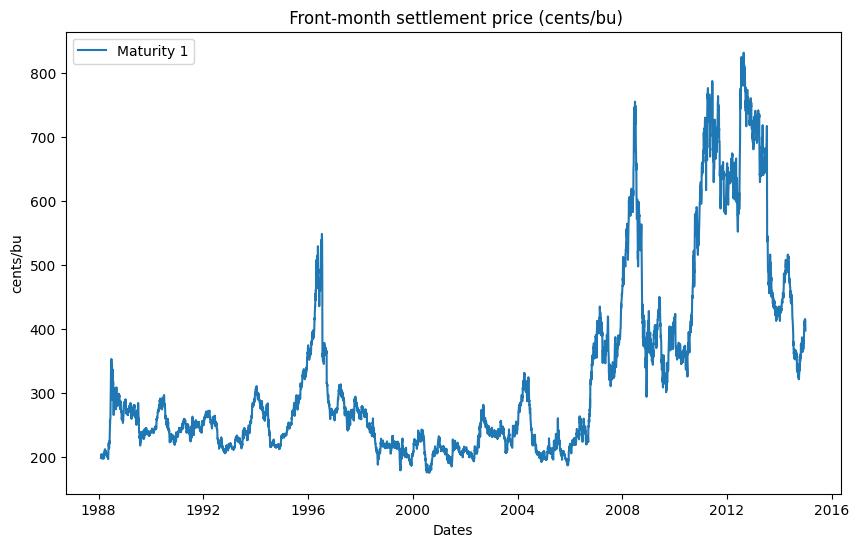

In [11]:
plot_time_series(df,["Maturity 1"], " Front-month settlement price (cents/bu)", "Dates", "cents/bu")

## Estimation du modele espace d'etat

In [12]:
from src.utility.date import get_t, get_T

df.reset_index(inplace=True)
df['t'] = df['index'].apply(get_t)
df[['T1', 'T2', 'T3', 'T4', 'T5']] = df['index'].apply(lambda x: pd.Series(get_T(x)))

In [13]:
df_log= pd.DataFrame({
    "index": df["index"]
})

for i in range(1, 6):
    df_log[f'log price Maturity {i}'] = np.log(df[f'Maturity {i}']) 
    
for i in range(1, 6):
    df_log[f'T {i}'] = (df[f'T{i}'] - df['index']).dt.days / 365 
df_log["t"] = df["t"]

df_log

,index,log price Maturity 1,log price Maturity 2,log price Maturity 3,log price Maturity 4,log price Maturity 5,T 1,T 2,T 3,T 4,T 5,t
0,1988-02-01,5.287004,5.316894,5.331510,5.339939,5.349486,0.117808,0.284932,0.452055,0.619178,0.871233,0.915068
1,1988-02-02,5.289529,5.316894,5.331510,5.335131,5.345916,0.115068,0.282192,0.449315,0.616438,0.868493,0.912329
2,1988-02-03,5.292048,5.318120,5.333926,5.338739,5.353042,0.112329,0.279452,0.446575,0.613699,0.865753,0.909589
3,1988-02-04,5.311974,5.336335,5.350673,5.358942,5.375278,0.109589,0.276712,0.443836,0.610959,0.863014,0.906849
4,1988-02-05,5.304548,5.332719,5.349486,5.356586,5.367144,0.106849,0.273973,0.441096,0.608219,0.860274,0.904110
...,...,...,...,...,...,...,...,...,...,...,...,...
6783,2014-12-24,6.010654,6.031286,6.047372,6.055026,6.069004,0.221918,0.389041,0.556164,0.723288,0.975342,0.019178
6784,2014-12-26,6.027676,6.047372,6.063204,6.069582,6.084499,0.216438,0.383562,0.550685,0.717808,0.969863,0.013699
6785,2014-12-29,6.022842,6.043226,6.059123,6.065528,6.079361,0.208219,0.375342,0.542466,0.709589,0.961644,0.005479
6786,2014-12-30,6.007584,6.028279,6.044413,6.051501,6.065528,0.205479,0.372603,0.539726,0.706849,0.958904,0.002740


In [14]:
from scipy.optimize import minimize
from src.model.kalman import KalmanModel
from src.utility.constant import mu, kappa, sigma1, sigma2, rho, lambdaz 

from scipy.optimize import minimize
from src.model.kalman import KalmanModel

def objective(params, observations, times, maturities, n_factors):
    """Objective function for Kalman Model optimization."""
    param_keys = ['mu', 'sigma1', 'lambda1', 'kappa2', 'sigma2', 'lambda2', 'rho12',
                  'kappa3', 'sigma3', 'lambda3', 'rho13', 'rho23',
                  'kappa4', 'sigma4', 'lambda4', 'rho14', 'rho24', 'rho34']
    model_params = {
        key: params[i] for i, key in enumerate(param_keys[:3 + 4 * (n_factors - 1)])
    }
    model_params['maturities'] = maturities
    model_params['current_time'] = times

    model = KalmanModel(n_factors=n_factors, params=model_params)
    return model.compute_likelihood(observations, times, maturities)

# Définition des variables pour la fonction objectif
observations = df_log.iloc[:, 1:6].values
times = df_log["t"].values
maturities = df_log.iloc[:, 6:11].values

# Initial guesses for parameters, adjust according to your model's need
initial_guesses = {
    1: [mu, sigma1, lambdaz],
    2: [mu, sigma1, lambdaz, kappa, sigma2, lambdaz, rho],
    3: [mu, sigma1, lambdaz, kappa, sigma2, lambdaz, rho, kappa, sigma2, lambdaz, rho, rho],
    4: [mu, sigma1, lambdaz, kappa, sigma2, lambdaz, rho, kappa, sigma2, lambdaz, rho, rho, kappa, sigma2, lambdaz, rho, rho, rho]
}

results = {}
for n_factors in range(1, 5):
    result = minimize(
        objective,
        initial_guesses[n_factors],
        args=(observations, times, maturities, n_factors),
        method='BFGS',
        options={'maxiter': 10}
    )
    results[n_factors] = result
    print(f"Optimized parameters for {n_factors} factors:", result.x)



Optimized parameters for 1 factors: [-0.01464567  0.17816909 -0.0576219 ]
Optimized parameters for 2 factors: [ 0.00409526  0.25659548 -0.06615365  0.92036343  0.31136923 -0.1011
 -0.73611095]
Optimized parameters for 3 factors: [ 0.04695245  0.19626683 -0.10645277  1.40789002  0.22791377 -0.1011
 -0.31585717 -0.01129871  0.22149375 -0.1011     -0.31626349 -0.3116    ]
Optimized parameters for 4 factors: [ 0.0416      0.1585     -0.1011      0.7744      0.2201     -0.1011
 -0.3116      0.77440002  0.2201     -0.1011     -0.3116     -0.3116
  0.7744      0.2201     -0.1011     -0.3116     -0.3116     -0.3116    ]
